Total Distance: 90.0 

Route for vehicle 1: [0, 3, 0]
Total Distance for vehicle 1: 30
Route for vehicle 2: [0, 1, 4, 2, 0]
Total Distance for vehicle 2: 60




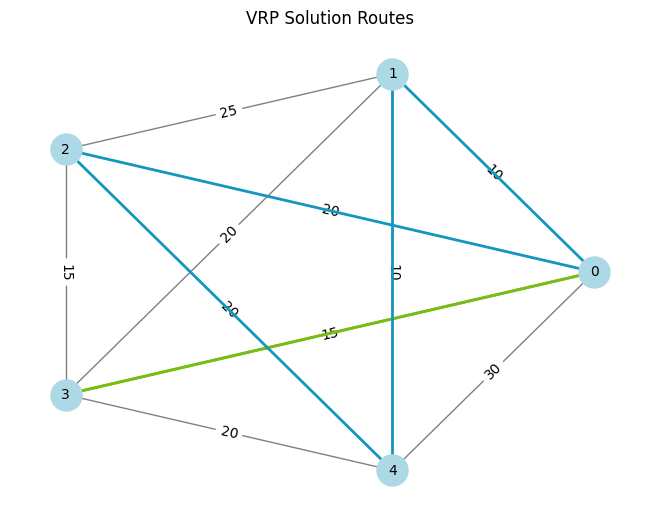

In [4]:
#!pip install pyomo
#!apt-get install -y -qq glpk-utils
from pyomo.environ import *
import matplotlib.pyplot as plt
import networkx as nx

def solve_VRP_with_pyomo(distance_matrix, demand, num_vehicles, depot=0, show_model=False, show_plot=True):
    num_locations = len(distance_matrix)
    locations = range(num_locations)

    # Initialize the Pyomo model
    vrp_model = ConcreteModel()

    # Sets
    vrp_model.Locations = RangeSet(num_locations)
    vrp_model.Vehicles = RangeSet(num_vehicles)

    # Parameters
    vrp_model.distance = Param(vrp_model.Locations, vrp_model.Locations, initialize=lambda model, i, j: distance_matrix[i-1][j-1], within=NonNegativeReals)
    vrp_model.depot = depot + 1  # Adjusted for Pyomo 1-indexed sets

    # Decision Variables
    vrp_model.x = Var(vrp_model.Locations, vrp_model.Locations, vrp_model.Vehicles, within=Binary)

    # Objective Function: minimize the total travel distance
    def obj_rule(model):
        return sum(model.distance[i, j] * model.x[i, j, k]
                   for i in model.Locations for j in model.Locations if i != j for k in model.Vehicles)
    vrp_model.obj = Objective(rule=obj_rule, sense=minimize)

    # Constraints

    # 1. Each customer is visited exactly once by one vehicle
    def visit_constraint(model, j):
        if j != model.depot:
            return sum(model.x[i, j, k] for i in model.Locations if i != j for k in model.Vehicles) == 1
        return Constraint.Skip
    vrp_model.visit_constraint = Constraint(vrp_model.Locations, rule=visit_constraint)

    # 2. Flow conservation for each vehicle
    def flow_constraint(model, k, i):
        if i != model.depot:
            return sum(model.x[i, j, k] for j in model.Locations if i != j) == sum(model.x[j, i, k] for j in model.Locations if i != j)
        return Constraint.Skip
    vrp_model.flow_constraint = Constraint(vrp_model.Vehicles, vrp_model.Locations, rule=flow_constraint)

    # 3. Depot start and end constraint for each vehicle
    def start_constraint(model, k):
        return sum(model.x[model.depot, j, k] for j in model.Locations if j != model.depot) == 1
    vrp_model.start_constraint = Constraint(vrp_model.Vehicles, rule=start_constraint)

    def end_constraint(model, k):
        return sum(model.x[i, model.depot, k] for i in model.Locations if i != model.depot) == 1
    vrp_model.end_constraint = Constraint(vrp_model.Vehicles, rule=end_constraint)

    # Solve the model
    SolverFactory('glpk').solve(vrp_model)

    # Show model details if requested
    if show_model:
        vrp_model.pprint()

    # Retrieve and print the solution
    if vrp_model.obj() is not None:
        print("Total Distance:", vrp_model.obj(), "\n")

        # Extract the solution routes for each vehicle
        routes = {k: [] for k in vrp_model.Vehicles}
        distances = {k: 0 for k in vrp_model.Vehicles}  # Store total distance for each vehicle

        # Build the routes based on the x variable values
        for k in vrp_model.Vehicles:
            route = [depot]
            total_distance = 0
            current_location = vrp_model.depot
            while True:
                next_location = next((j for j in vrp_model.Locations if j != current_location and vrp_model.x[current_location, j, k].value == 1), None)
                if next_location is None or next_location == vrp_model.depot:
                    break
                route.append(next_location - 1)  # Adjust for original 0-indexed list
                total_distance += distance_matrix[current_location - 1][next_location - 1]
                current_location = next_location
            route.append(depot)
            total_distance += distance_matrix[current_location - 1][depot]  # Add return to depot
            routes[k] = route
            distances[k] = total_distance
            print(f"Route for vehicle {k}: {route}")
            print(f"Total Distance for vehicle {k}: {total_distance}")

        # Plot the routes if requested
        if show_plot:
            print("\n")
            plot_vrp_solution(distance_matrix, routes)
    else:
        print("No optimal solution found.")

def plot_vrp_solution(distance_matrix, routes):
    G = nx.Graph()
    num_locations = len(distance_matrix)

    for i in range(num_locations):
        for j in range(i + 1, num_locations):
            if distance_matrix[i][j] > 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{distance_matrix[i][j]}" for i, j in G.edges()})

    colors = ["#bd1435", "#78bd14", "#1497bd", "purple", "orange", "pink"]
    for k, route in routes.items():
        route_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=2, edge_color=colors[k % len(colors)])

    plt.title("VRP Solution Routes")
    plt.show()

# Example usage
if __name__ == "__main__":
    distance_matrix = [
        [0, 10, 20, 15, 30],
        [10, 0, 25, 20, 10],
        [20, 25, 0, 15, 20],
        [15, 20, 15, 0, 20],
        [30, 10, 20, 20, 0]
    ]
    demand = [0, 10, 20, 30, 40]  # 0 demand for the depot (not used in VRP)
    num_vehicles = 2

    solve_VRP_with_pyomo(distance_matrix, demand, num_vehicles, show_model=False, show_plot=True)